In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

In [2]:
stringSST = "300" ##295, 300 or 305
n_days = 25
chunk_size = {'time' :48, 'x' : 32, 'y' : 32}
label_chunk_size = {'time' :48, 'longitude' : 32, 'latitude' : 32}

#TOOCAN segmentation masks (les labels des objets MCS, dans la grille originale x,y,t)
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/TOOCAN_2.07_SAM_RCE_large'+stringSST+'_2D_irtb.nc'

# TOOCAN objects (list d'objets MCS, leur labels et leur caractéristiques)
file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/FileTracking/TOOCAN-SAM_RCE_large'+stringSST+'_2D_irtb.dat.gz'

sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

# Import SAM Distrib, MCS list, and label mask

In [3]:
# File doesn't exist, create the object
# Create a Dask client
client = ddistributed.Client()

# Open native precip datasets
ds1 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_1.nc", chunks = chunk_size)
ds2 = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_"+stringSST+"K_64.2Dcom_2.nc", chunks = chunk_size)

# Combine datasets
ds = xr.concat([ds1, ds2], dim='time')
# Rename dimensions
ds["x"] = ((ds["x"])/3e3).astype(int)
ds["y"] = (ds["y"]/3e3).astype(int) 
ds["time"] = np.round(((ds["time"]-75)*48)).astype(int)
ds = ds.isel(time = slice(0, 48*n_days)) 

distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-zpph05b1', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-hmgtgmtl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-mfvexs7a', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/mcarenso/dask-worker-space/worker-xiz2y3e1', purging


In [5]:
filename = 'dist_SAM_Native_Prec_sizemax_1e7.pkl' # used for import or saving the object
path = '/homedata/mcarenso/distrib/'  # my desired directory path

# Check if the file exists
if os.path.isfile(os.path.join(path, filename)):
    # File exists, load the object
    with open(os.path.join(path, filename), 'rb') as file:
        dist_SAM_Prec = pickle.load(file)
else:
    dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 6, fill_last_decade=True)
    dist_SAM_Prec.computeDistribution(sample = ds["Prec"].stack(flat=('time', 'y', 'x')).to_numpy())
    dist_SAM_Prec.storeSamplePoints(sample = ds["Prec"].stack(flat=('time', 'y', 'x')).to_numpy(), sizemax = int(1e7))

    # Save the object as a file
    with open(os.path.join(path, filename), 'wb') as file:
        pickle.dump(dist_SAM_Prec, file)

size = dist_SAM_Prec.size
ds_SAM_shape = (size//(128*2048), 128, 2048)

In [6]:
## Import MCS list and prepare label list

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)

In [7]:
label_mask = xr.open_dataarray(file_seg).isel(time=slice(48*n_days)).chunk(label_chunk_size)

## function to retrieve the indexes in MCS by MCS labels, could be put in myFuncs but need label_list from the tracking file
MCS_6h = [MCS[i] for i in range(len(MCS)) if MCS[i].duration in [12]] ## TODO : add the symetry if here
MCS_6h_labels = [MCS_6h[i].label for i in range(len(MCS_6h))]

def idx_by_label(labels, label_list = MCS_6h_labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs
# Put to nan the labels that are not in MCS_6h_labels
label_6h_mask = label_mask.where(label_mask.isin(MCS_6h_labels))

### What is the percentage of rain that falls from under an MCS ? (depending on bins here)

In [12]:
from myFuncs import count_rel_nan

path_data = '/homedata/mcarenso/data/'  # my desired directory path
filename = 'perc_MCS_over_rain_'+stringSST+'.pkl'

# check if perc_MCS_over_rain is already computed and saved in homedata 
if os.path.isfile(os.path.join(path_data, filename)):
    # File exists, load the object
    with open(os.path.join(path_data, filename), 'rb') as file:
        perc_MCS_over_rain = pickle.load(file)
else: ## compute it
    perc_MCS_over_rain = []
    for i,bin_loc in enumerate(dist_SAM_Prec.bin_locations):
        
        #print(np.round(dist_SAM_Prec.ranks[i], 4), len(x)) 
        ## Retrieve array of (x,y,t)s per bins that correspond to native precipitations 
        idxs_subs = np.unravel_index(bin_loc, ds_SAM_shape)

        ## Get the labels of MCS for these (x,y,t)s
        labels= label_mask.values[idxs_subs] ## label is nan if there is no MCS over this idx
        perc_MCS_over_rain.append(1-count_rel_nan(labels))  
    # and save it 
    with open(os.path.join(path_data, filename), 'wb') as file:
        pickle.dump(perc_MCS_over_rain, file)

check that the curve bounds match
x bounds: 0.0 99.9999
y bounds: 0.0 4037.3954703996096



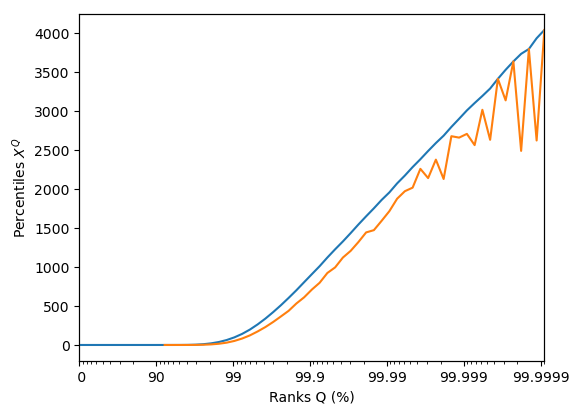

In [13]:
%matplotlib inline
fig,ax = plt.subplots(ncols=1,figsize=(6,4.5))

ranks = dist_SAM_Prec.ranks
perc = dist_SAM_Prec.percentiles

#--- on IL x axis
ax_show = ax.twiny()

#- set frame
setXaxisIL(ax,ranks)

#- show data
showData(ax_show,ranks,perc, rankmin=0, rankmax = 99.9999)
showData(ax_show, ranks, perc*perc_MCS_over_rain, rankmin=0, rankmax = 99.9999)

#- labels
ax.set_xlabel('Ranks Q (%)')
ax.set_ylabel('Percentiles $X^Q$')

print('check that the curve bounds match')
print('x bounds:',ranks[0],ranks[-1])
print('y bounds:',perc[0],perc[-1])
print()

# Native extremes over their MCS LifeCycle

### What is the mean age of MCS per rainfall extremes ? 

In [ ]:
import time 
start_time = time.time()
data_per_bin = []
for i,bin_loc in enumerate(dist_SAM_Prec.bin_locations):
    ## list per iteration to average.
    bin_data = []

    ## Retrieve coord array of (x,y,t)s per bins. tuple form is usefull for subscritapility and array form is usefull for iterating over.
    
    coord_subs = np.unravel_index(np.array(bin_loc, dtype = np.intp), ds_SAM_shape) ## 3-uplet of 1D array that represents  time, y and x. access like idxs_subs[2][i] for the x value of the ith index                                               
    labels = label_6h_mask.values[coord_subs]            ## Get the labels of MCS for these (x,y,t)s, 
    labels_no_nan = [x for x in labels if not math.isnan(x)] ## for now remove Nans and don't discriminate MCS that may occurs multiple time.
    MCSs = [MCS[idx] for idx in idx_by_label(labels_no_nan)] ## Retrieve MCS from correct idx_by_label and label_list
    if len(labels)>0 : print(len(labels_no_nan)/len(labels), "% of Native precips that were lost for the rank :", dist_SAM_Prec.ranks[i])

    coord_read = np.vstack(coord_subs).T # np.array of coordinates np.array(time, y, x) of the bin
    coord_no_nan = [idx for i, idx in enumerate(coord_read) if not math.isnan(labels[i])] ## coord correspond to (x,y,t), used as indexing for original dataset

    
    for i in range(len(MCSs)):
        #bin_ages.append(coord_no_nan[i][0] - MCSs[i].TimeInit)
        Age_MCS = coord_no_nan[i][0] - MCSs[i].TimeInit + 2
        if Age_MCS <= 0 : print("Weird MCS age : ", coord_no_nan[i][0] - MCSs[i].TimeInit + 2, "has label : ", MCSs[i].label)
        bin_data.append((Age_MCS)/MCSs[i].duration)
    data_per_bin.append(bin_data)

print("--- %s seconds for 1st method which iterates over bin ---" % (time.time() - start_time))

In [ ]:
%matplotlib inline
nrows = 1
fig, ax = plt.subplots(nrows = 1, ncols=1, figsize= (14, 6))
x=dist_SAM_Prec.ranks
Age_Over_bins = data_per_bin
setXaxisIL(ax, x)
ax_show = ax.twiny()
ax_show.boxplot(Age_Over_bins)
ax_show.set_xticks([])

ax.set_xlabel("Native Precipitation Ranks")

ax.set_ylabel("Relative Age of precipitation under MCS")
plt.legend()
plt.title("Relative Age of MCS of about 6h duration")
plt.tight_layout()
plt.show()

## Let's add MCS classification (Roca 2017)

In [ ]:
from myFuncs import calculate_first_derivative, classify_derivative

In [ ]:
print("Goodbye world !")